# Store the metadata of an image stored externally on Azure Blob storage

In [1]:
# load dataset from hf
from datasets import load_dataset

dataset = load_dataset("Elriggs/imagenet-50-subset")

train_dataset = dataset['train']
val_dataset = dataset['validation']

d:\Bachelor\Curriculum\HK251\DBMS\elastic-search\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:

from azure.storage.blob import BlobServiceClient

# dataset loading and image encoding
import base64
from io import BytesIO
import PIL
import os
from dotenv import load_dotenv

# upload images to Azure Blob Storage
def image_to_binary(image) -> bytes:
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='JPEG')
    img_bytes = img_byte_arr.getvalue()
    return img_bytes

def upload_image_to_azure(image, blob_service_client: BlobServiceClient, container_name: str, blob_name: str) -> str:
    img_bytes = image_to_binary(image)
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)
    blob_client.upload_blob(img_bytes, overwrite=False)
    blob_url = blob_client.url
    return blob_url

load_dotenv()
connection_str = os.getenv("AZURE_STORAGE_CONNECTION_STRING")
blob_service_client = BlobServiceClient.from_connection_string(connection_str)
storage_name = "esimagedatastorage"
container_name = "imagenet-100"

In [ ]:
from dataclasses import dataclass
from typing import List

@dataclass
class ImageMeta:
    id: int
    wnid: str
    label: str
    class_name: str
    blob_url: str
    height: int
    width: int
    
def recreate_container(blob_service_client: BlobServiceClient, container_name: str):
    blob_service_client.create_container(container_name)
    print(f"Created container {container_name}")
    
def get_imgs_urls(dataset, storage_name, container_name="imagenet-100", start=0, num_imgs=100) -> List[str]:
    img_urls = []
    for i in range(start, start + num_imgs):
        sample = dataset[i]
        img_url = f"https://{storage_name}.blob.core.windows.net/{container_name}/{sample['wnid']}_{i}.jpeg"
        img_urls.append(img_url)
    return img_urls

def upload_images_to_azure(dataset, blob_service_client: BlobServiceClient, container_name: str, start=0, num_imgs=100) -> List[ImageMeta]:
    img_metas = []
    for i in range(start, start + num_imgs):
        sample = dataset[i]
        image = sample['image']
        blob_name = f"{sample['wnid']}_{i}.jpeg"
        blob_url = upload_image_to_azure(image, blob_service_client, container_name, blob_name)
        img_meta = ImageMeta(
            id=i,
            wnid=sample['wnid'],
            label=sample['label'],
            class_name=sample['class_name'],
            blob_url=blob_url,
            height=image.height,
            width=image.width
        )
        img_metas.append(img_meta)
        if i % 10 == 0:
            print(f"Uploaded image {i} to {blob_url}")
    return img_metas
        
# recreate_container(blob_service_client, container_name)
# get_imgs_urls(train_dataset, storage_name, container_name, start=0, num_imgs=50)
img_metas = upload_images_to_azure(train_dataset, blob_service_client, container_name, start=0, num_imgs=50)

Uploaded image 0 to https://esimagedatastorage.blob.core.windows.net/imagenet-100/n01440764_0.jpeg
Uploaded image 10 to https://esimagedatastorage.blob.core.windows.net/imagenet-100/n01440764_10.jpeg
Uploaded image 20 to https://esimagedatastorage.blob.core.windows.net/imagenet-100/n01440764_20.jpeg
Uploaded image 30 to https://esimagedatastorage.blob.core.windows.net/imagenet-100/n01440764_30.jpeg
Uploaded image 40 to https://esimagedatastorage.blob.core.windows.net/imagenet-100/n01440764_40.jpeg


## Connect and load images metadatas onto Elastic Search

In [24]:
from elasticsearch import Elasticsearch
from typing import List

es = Elasticsearch(
    hosts=["https://localhost:9200"],
    basic_auth=("elastic", os.getenv("ES_PASSWORD")),
    ca_certs="http_ca.crt"
)
if es.ping():
    print("Connected to ES")
else:
    print("Could not connect to ES")

# create index
index_name = "imagenet-50-metadata"
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)
    print(f"Deleted index {index_name}")
es.indices.create(index=index_name)

def load_images_to_es(imgs, es: Elasticsearch, index_name: str, start=0, num_imgs=100):
    for idx, img in enumerate(imgs[start:start + num_imgs]):
        doc = {
            "id": img.id,
            "wnid": img.wnid,
            "label": img.label,
            "blob_url": img.blob_url,
            "height": img.height,
            "width": img.width
        }
        es.index(index=index_name, document=doc)
        if idx % 10 == 0:
            print(f"Indexed image {img.id} to ES")

load_images_to_es(img_metas, es, index_name, start=0, num_imgs=100)

Connected to ES
Deleted index imagenet-50-metadata
Indexed image 0 to ES
Indexed image 10 to ES
Indexed image 20 to ES
Indexed image 30 to ES
Indexed image 40 to ES


img_10 response: {'_index': 'imagenet-50-metadata', '_id': 'BdNWSZkBI9iXiDISI_TF', '_score': 1.0, '_source': {'id': 10, 'wnid': 'n01440764', 'label': 0, 'blob_url': 'https://esimagedatastorage.blob.core.windows.net/imagenet-100/n01440764_10.jpeg', 'height': 146, 'width': 223}}
Blob URL: https://esimagedatastorage.blob.core.windows.net/imagenet-100/n01440764_10.jpeg


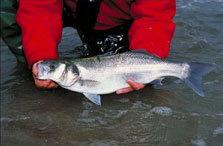

In [32]:
import requests

# get image from ES by its metadata
def get_img_from_url(url: str) -> PIL.JpegImagePlugin.JpegImageFile:
    response = requests.get(url)
    image = PIL.Image.open(BytesIO(response.content))
    return image

img_10_response = es.search(index=index_name, query={"match": {"id": 10}})['hits']['hits'][0]
print("img_10 response:", img_10_response)
print("Blob URL:", img_10_response['_source']['blob_url'])

# get image from blob_url
if img_10_response:
    img_10 = get_img_from_url(img_10_response['_source']['blob_url'])
    
img_10